In [3]:
import numpy as np
import pandas as pd
import seaborn
import torch
from IPython.display import HTML
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD

from utils.vis import plot_decision_space, visualize_data


RANDOM_STATE = 45

np.random.seed(RANDOM_STATE)

%matplotlib inline

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(7)


# Prepare and Visualize data

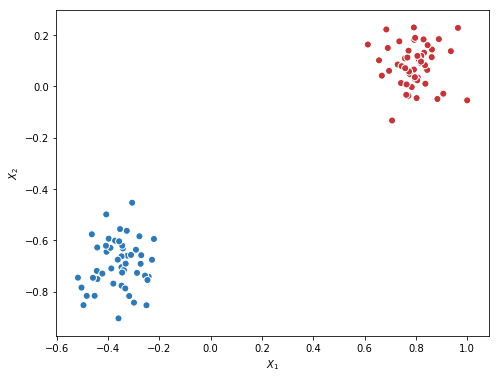

In [4]:
N_FEATURES = 2

X, Y = make_blobs(centers=2, random_state=RANDOM_STATE, n_features=N_FEATURES)
# X, Y = make_moons(n_samples=1000)
X = X/np.abs(X).max()
visualize_data(X,Y)


In [5]:
data = pd.DataFrame(X, columns=['x1','x2'])
data['target'] = Y
data

,x1,x2,target
0,0.707380,-0.133517,0
1,-0.316867,-0.817494,1
2,0.792607,0.064959,0
3,-0.323771,-0.660196,1
4,-0.405178,-0.645079,1
5,-0.272355,-0.691914,1
6,0.667548,0.041223,0
7,-0.386545,-0.710139,1
8,-0.346698,-0.777073,1
9,-0.249515,-0.853540,1


In [6]:
pd.DataFrame(Y).head()

,0
0,0
1,1
2,0
3,1
4,1


# Define the perceptron


![alt text](https://cdn-images-1.medium.com/max/1600/1*-JtN9TWuoZMz7z9QKbT85A.png "Title")


In [7]:

input_tensor = torch.randn((1,2))

linear_layer = nn.Linear(2, 1, bias=False)

linear_layer(input_tensor)

print(linear_layer.weight)
print(input_tensor)
output = linear_layer(input_tensor)
print(output)

print(input_tensor.shape)
manual_output = input_tensor.mm(linear_layer.weight.transpose(0, 1))
print(manual_output)
assert output == manual_output

Parameter containing:
tensor([[-0.3779, -0.1060]], requires_grad=True)
tensor([[-0.1468,  0.7861]])
tensor([[-0.0278]], grad_fn=<MmBackward>)
torch.Size([1, 2])
tensor([[-0.0278]], grad_fn=<MmBackward>)


In [8]:

class Perceptron(nn.Module):
    def __init__(self, n_in):

        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(2, 10, bias=True)
        self.fc2 = nn.Linear(10, 1, bias=True)
        
    
    def forward(self, x):
        return self.fc2(self.fc1(x))

def custom_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.zeros_(m.weight)
        m.weight.fill_(0)
        m.bias.data.fill_(0)
        
perceptron = Perceptron(2)

# Linear layers get their weights initialized by default, but you can reinitialize them if needed.
# perceptron.apply(custom_weights)

# print("fc weight", perceptron.fc.weight)
# print("bias weight", perceptron.fc.bias)

In [9]:
[p for p in dir(perceptron) if not p.startswith('_')]

['add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'fc1',
 'fc2',
 'float',
 'forward',
 'half',
 'load_state_dict',
 'modules',
 'named_buffers',
 'named_children',
 'named_modules',
 'named_parameters',
 'parameters',
 'register_backward_hook',
 'register_buffer',
 'register_forward_hook',
 'register_forward_pre_hook',
 'register_parameter',
 'share_memory',
 'state_dict',
 'to',
 'train',
 'training',
 'type',
 'zero_grad']

# Train Loop Using CrossEntropy



While using crossentropy loss our model needs to return (BS, n_classes) output tensor, the target has to be a coresponding dense label vector of shape (BS, 1)

In [10]:
# list(net.pa)
net = Perceptron(2)
list(net.parameters())
optimizer = SGD(net.parameters(), lr=0.01)
optimizer.__dict__

{'defaults': {'lr': 0.01,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False},
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([[-0.0913,  0.3350],
            [-0.6603, -0.5779],
            [ 0.5648,  0.6981],
            [-0.0420, -0.5587],
            [ 0.0193, -0.3290],
            [-0.0014,  0.3461],
            [ 0.3130, -0.0829],
            [ 0.0778,  0.1924],
            [-0.5542, -0.2397],
            [ 0.0277, -0.4035]], requires_grad=True), Parameter containing:
    tensor([-0.3088,  0.2375,  0.4070,  0.0099, -0.2751,  0.3872, -0.3876, -0.1660,
             0.6671,  0.1302], requires_grad=True), Parameter containing:
    tensor([[ 0.0223,  0.1066, -0.0771,  0.2706, -0.2579, -0.0870, -0.0547, -0.1301,
             -0.0783,  0.1960]], requires_grad=True), Parameter containing:
    tensor([0.1735], requires_grad=True)],
   'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nestero

training epoch 0
training epoch 1
training epoch 2
input shape (BS, n_classes): torch.Size([1, 2])
target shape (BS, 1): torch.Size([1, 1])
output shape torch.Size([1, 1])


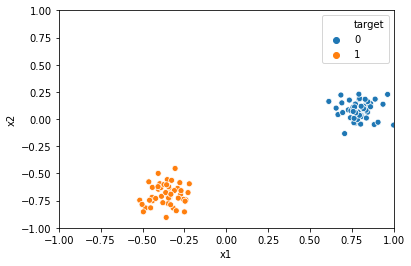

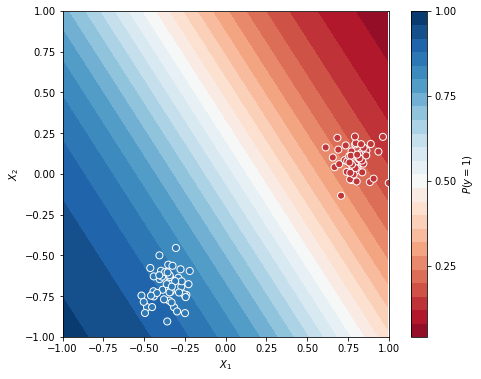

In [11]:


N_EPOCHS = 3

# init the model, loss and optimizer
net = Perceptron(2)

optimizer = SGD(net.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
net = net.to(DEVICE)

loss_history = []
# neural_network.fit(X, y)
for epoch in range(N_EPOCHS):
    print("training epoch {}".format(epoch))
    
    for xsample,ysample in zip(X, Y):
        optimizer.zero_grad() 
        # zero the gradients
        
        # batch preparation

        x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
        y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
#         if True:
#             ix = np.random.randint(0, size=(4,), high=len(X))
#             x = torch.tensor((X[ix, :])).float()
#             y = torch.tensor(torch.Tensor(Y[ix]).reshape(-1,1)).float()
#             x = x.to(DEVICE)
#             y = y.to(DEVICE)
        
        # forward pass
        out = net(x)

        # loss calculation
        loss = criterion(out, y)

        # calculating gradients
        loss.backward()

        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()
        
        #append calculated loss to the history
        loss_history.append(loss.detach().cpu().numpy())
#     calculate_acc(net, X, Y)
        
#     plot_decision_boundry(net, X)
# at the end plot final solution in red
# plot_decision_boundry(net, X, 'r-')
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plot_decision_space(net, X, Y)
        
print("input shape (BS, n_classes):", x.shape)
print("target shape (BS, 1):", y.shape)
print("output shape", out.shape)

# def score_model(net, X, Y)

Text(0, 0.5, 'loss (CE)')

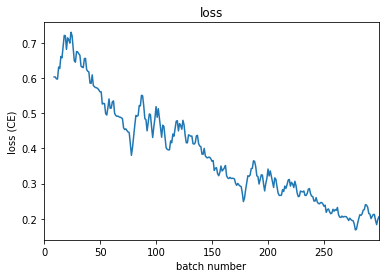

In [12]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss[:].rolling(10).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

# history[::10].plot()


## Exercises
1) Play with the training loop, enojoy the fact that you can inspect all the values dynamically. Consider using pdb.set_trace() for instance  
2) Can you edit the Perceptron class to create a Multi Layer Perceptron? (ie having more then 0 hidden layers)  
3) Initialize the the initial weights to 0. What do you think will happen? Can we still train the perceptron?  
4) What kind of gradient descnet are we using here? Stochastic? Batch? or Vanilla?  
5) What does detach do and why do we have to call it? (use google)  
6) Try adding a RELU activation after Linear unit - Will it train?
7) Try to implement (or use a ready-made solution) for a progress-bar for the training loop (it might come in handy in our future exercises to)  
8) We can see the loss never going to 0, but the accuracy probably is reaching 100% - calculate ACC each epoch
9) Change the dataset to moons, can you rache close to 100% accuracy on it? What needs to be changed.  
10) In the training loop there is commented block of code - what is it doing?  

In [ ]:
HTML('<iframe src=https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.19214&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false width=1000 height=600></iframe>')